In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from utilities_namespace import *

In [9]:
%%capture
%load_ext rpy2.ipython
%R require(ggplot2)

In [3]:
from helpers.notebooks import notebooks_importer

In [4]:
%%capture
import Breast_cancer_data as data

In [5]:
from signature_scoring.scoring_functions.gsea import create_gsea_scorer
from gsea_api import cudaGSEA, GSEADesktop

In [6]:
from functools import partial

In [7]:
from signature_scoring.evaluation.benchmark import benchmark

In [8]:
from signature_scoring.evaluation.display import summarize

In [9]:
standard_benchmark = partial(
    benchmark,
    top='quantile',                           # criterium for selection of the candidated repositioning substances; quantile: choose top 10%
    summary='per_cell_line_combined',         # use combine() method of evaluation metrics to combine metrics results calculated for each of the cell lines
    aggregate='mean_per_substance_and_dose',  # same as "mean_per_substance_dose_and_cell" because summary is computed per cell line anyway (see above)
    cell_lines_ratio=.75,                     # at least such a ratio of substances signatures should be available for the cell line to include it
    limit=500,                                # how many under- and over- expressed genes should be analyzed
    processes=7,
    per_test_progress=False
)

In [10]:
standard_brca_benchmark = partial(
    standard_benchmark,
    indications_signatures=data.indications_singatures,
    contraindications_signatures=data.contraindications_singatures,  # TODO: typo in data
    query_expression=data.brca_with_controls,
    # these two are for single sample functions that do not use controls (not needed here)
    query_signature=None,
    control_signatures=None
)

## Some notes on cudaGSEA

### Versions:
- Driver Version: 415.27
- CUDA Version: 10.0
- GeForce GTX 950M (640 GPU cores, 4046 MB)

cudaGSEA is executed one by one on the GPU core but the time when it is not being executed can be used to prepare the queue for the GPU core. So the number of processes basically tells how many tasks I wish to put on the queue.

Each task takes up to ~140 MB when 1000 permutations is used. My Nvidia card has 4046 MiB so it should be possible to have 28 processes up and waiting. However, in the benchmark below I use only seven cores as the Java version runs on CPU only.

### FDR calculation

cudaGSEA was published without FDR calculation, which is required for my scoring function.

I implemented FDR using two approaches:
 - as in the original GSEA paper (Subramanian, 2005) - the default one
 - reusing FDR-function from my previous implementation of GSEA (originally in Python) which does *not* look at positive and negative NES scores separately - let's call it "approximate FDR"
 
The approximate FDR has lower complexity so it should be faster to calculate. Below I show that both the approaches produce values close to those generated by reference (Java) GSEA Desktop implementation.

And here is the link to [my changes in cudaGSEA](https://github.com/gravitino/cudaGSEA/compare/master...krassowski:with_approximate_fdr?expand=1). 

In [11]:
gsea_desktop = GSEADesktop()
gsea_cuda = cudaGSEA()
gsea_cuda_approx = cudaGSEA(fdr='approximate')
gsea_cuda_cpu = cudaGSEA(use_cpu=True) # same as gsea_cuda but calculated on CPU

# Results

## 1. My cudaGSEA FDR q-value algorithms  behave similarly to the reference GSEA Desktop implementation

The approximate FDR algorithm is much worse, but still better at approximating FDR than if we were just to look at the p-values.

Please see attached figure (about 10 cells below).

In [12]:
from data_sources.molecular_signatures_db import MolecularSignaturesDatabase

In [13]:
db = MolecularSignaturesDatabase()
db.load('c2.cp.kegg', 'entrez').trim(min_genes=15, max_genes=500).to_gmt('trimmed_kegg.gmt')

In [14]:
def benchmark_app(app):
    results = app.run(data.brca_with_controls, 'trimmed_kegg.gmt', id_type='entrez')
    return concat([results['normal'], results['tumor']])

In [15]:
result_desktop = benchmark_app(app=gsea_desktop)
result_cuda = benchmark_app(app=gsea_cuda)
result_cuda_approx = benchmark_app(app=gsea_cuda_approx)

In [16]:
fdr_comparison = DataFrame(dict(
    cuda_full_fdr=result_cuda['fdr_q-val'],
    desktop_fdr=result_desktop['fdr_q-val'],
    desktop_p=result_desktop['nom_p-val'],
    cuda_p=result_cuda['nom_p-val'],
    cuda_approx_fdr=result_cuda_approx['fdr_q-val']
))
# desktop_fdr is the reference
fdr_comparison = fdr_comparison.sort_values('desktop_fdr').reset_index().rename({'index': 'gene_set'}, axis=1)
fdr_comparison.head()

,gene_set,cuda_full_fdr,desktop_fdr,desktop_p,cuda_p,cuda_approx_fdr
0,KEGG_BASE_EXCISION_REPAIR,0.037372,0.030196,0.003868,0.003,0.045000
1,KEGG_PYRIMIDINE_METABOLISM,0.038419,0.038695,0.000000,0.003,0.047000
2,KEGG_DNA_REPLICATION,0.029527,0.039528,0.001996,0.004,0.035500
3,KEGG_HOMOLOGOUS_RECOMBINATION,0.033622,0.041460,0.005964,0.013,0.041200
4,KEGG_N_GLYCAN_BIOSYNTHESIS,0.037205,0.043456,0.000000,0.003,0.045333


In [17]:
to_plot = fdr_comparison.melt(id_vars=['gene_set'])
to_plot['gene_set'] = pd.Categorical(to_plot['gene_set'], ordered=True, categories=fdr_comparison.gene_set)
to_plot.head()

,gene_set,variable,value
0,KEGG_BASE_EXCISION_REPAIR,cuda_full_fdr,0.037372
1,KEGG_PYRIMIDINE_METABOLISM,cuda_full_fdr,0.038419
2,KEGG_DNA_REPLICATION,cuda_full_fdr,0.029527
3,KEGG_HOMOLOGOUS_RECOMBINATION,cuda_full_fdr,0.033622
4,KEGG_N_GLYCAN_BIOSYNTHESIS,cuda_full_fdr,0.037205


In [18]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

def pearsonr_score(x, y):
    return pearsonr(x, y)[0]

clean_comparison = fdr_comparison.dropna()

stats = DataFrame({
    stat.__name__: Series({
        other: stat(clean_comparison['desktop_fdr'], clean_comparison[other])
        for other in fdr_comparison.columns
        if other not in ['gene_set']
    })
    for stat in [r2_score, pearsonr_score]
})
stats

,r2_score,pearsonr_score
cuda_full_fdr,0.847134,0.939899
desktop_fdr,1.000000,1.000000
desktop_p,0.536972,0.963968
cuda_p,0.116286,0.731020
cuda_approx_fdr,0.716759,0.897859


In [19]:
annotations = stats.reset_index().rename({'index': 'variable'}, axis=1)
annotations.r2_score = annotations.r2_score.apply(lambda r2: f"R^{2}*'= {r2:.2f}'")
annotations.pearsonr_score = annotations.pearsonr_score.apply(lambda r: f'r = {r:.2f}')

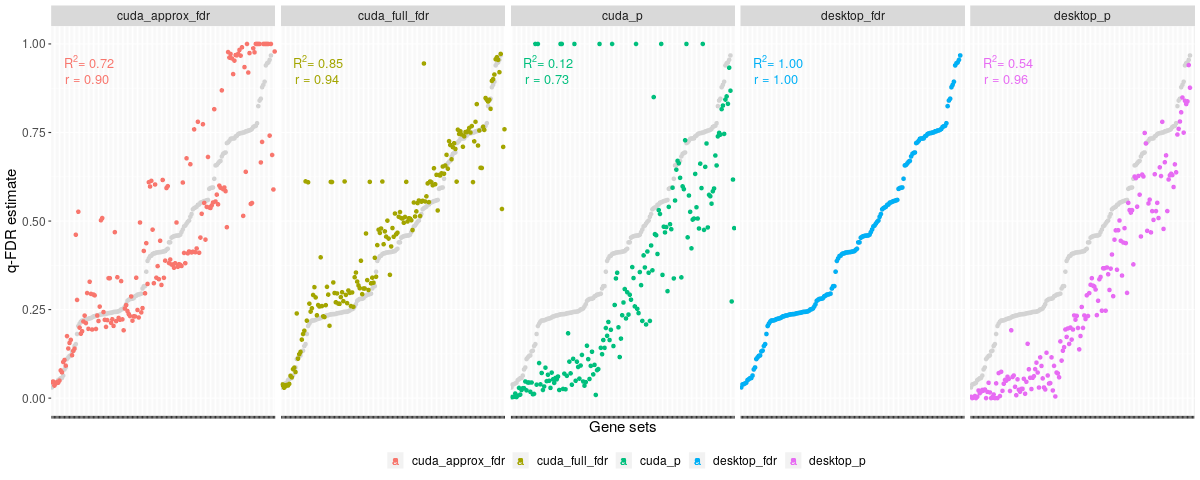

In [20]:
%%R -i to_plot -i annotations -w 1200
g = (
    ggplot(to_plot, aes(x=gene_set, y=value, color=variable))
    + geom_point(data=to_plot[to_plot$variable == 'desktop_fdr', c('gene_set', 'value')], color='lightgrey')
    + geom_text(data=annotations, aes(x=-Inf, y=0.95, label=r2_score), hjust=-0.25, parse=T, size=4.5)
    + geom_text(data=annotations, aes(x=-Inf, y=0.90, label=pearsonr_score), hjust=-0.315, size=4.5)
    + geom_point()
    + facet_grid('. ~ variable')
    + theme(axis.text.x = element_blank(), legend.position='bottom', legend.box='horizontal', text=element_text(size=15))
    + xlab('Gene sets')
    + ylab('q-FDR estimate')
    + guides(color=guide_legend(title=''))
)
ggsave(file="cuda_gsea_benchmark.svg", plot=g, width=12, height=5)
g

## 2. cudaGSEA is on average 6 times faster (in the real scoring scenario)

Not two orders of magnitude as marketed by the original developers (though I do not have such a powerful card as they did - possibly my CPU is just relatively more powerful). So I do not say that the original method was not two orders of magnitue faster, but that after adding FDR and the cost of file preparation etc, the real benefit is only about 6 times speedup. 

In [11]:
tcga_genes = set(data.query_signature.index.astype(str))

In [12]:
shared_gsea_scorer = partial(
    create_gsea_scorer, gene_sets='c2.cp.kegg',
    permutation_type='phenotype', grouping='by_substance',
    verbose=False, genes=tcga_genes
)

In [15]:
def rename_function(scoring_function, old, new):
    scoring_function.__name__= scoring_function.__name__.replace(old, new)

In [12]:
speed_compared_functions = []

for p in [10, 50, 100, 500, 1000]:

    common_gsea_setup = partial(
        shared_gsea_scorer,
        permutations=p, q_value_cutoff=0.5,
    )

    gsea_score_phenotypes_java = common_gsea_setup(gsea_app=gsea_desktop, metric='Signal2Noise')
    gsea_score_phenotypes_cuda = common_gsea_setup(gsea_app=gsea_cuda, metric='twopass_signal2noise')
    gsea_score_phenotypes_cuda_approx = common_gsea_setup(gsea_app=gsea_cuda_approx, metric='twopass_signal2noise')
    rename_function(gsea_score_phenotypes_cuda_approx, 'cudaGSEA', 'cudaGSEAapprox')
    gsea_score_phenotypes_cuda_cpu = common_gsea_setup(gsea_app=cudaGSEA(cpu=True), metric='twopass_signal2noise')
    rename_function(gsea_score_phenotypes_cuda_cpu, 'cudaGSEA', 'cudaGSEAcpu')

    speed_compared_functions.extend([
        gsea_score_phenotypes_cuda,
        gsea_score_phenotypes_cuda_approx,
        gsea_score_phenotypes_java,
        gsea_score_phenotypes_cuda_cpu
    ])

In [27]:
speed_benchmark_results = standard_brca_benchmark(speed_compared_functions)

'Iteration: 641/1000 for tmpgcr4au8q.tmp60y755_9'

'Iteration: 646/1000 for tmpgcr4au8q.tmp60y755_9'

'Iteration: 651/1000 for tmpgcr4au8q.tmp60y755_9'

'Iteration: 656/1000 for tmpgcr4au8q.tmp60y755_9'

'Iteration: 661/1000 for tmpgcr4au8q.tmp60y755_9'

In [28]:
speed_benchmark_results.to_csv('cudaGSEA benchmarks/speed_benchmark_results_with_cpu.csv')

In [236]:
speed_benchmark_data = DataFrame(dict(
    permutations=speed_benchmark_results.index.str.split('_').str[1].astype(int),
    app=pd.Categorical(speed_benchmark_results.index.str.split('_').str[0]),
    speed=speed_benchmark_results['Time'],
    auc=speed_benchmark_results['contraindications:AUC ROC'],
    auc_class=speed_benchmark_results['contraindications:AUC ROC classification'],
    f1=speed_benchmark_results['indications:F1 Score']
))

In [83]:
desktop_performance = speed_benchmark_data.query('app == "GSEADesktop"')
for cuda_variant in ['cudaGSEA', 'cudaGSEAapprox', 'cudaGSEAcpu']:
    cuda_performance = speed_benchmark_data.query('app == @cuda_variant')
    merged = desktop_performance.merge(cuda_performance, on=['permutations'])
    speed_ratio = merged.speed_x / merged.speed_y
    print(f'mean(GSEADesktop / {cuda_variant}) = {speed_ratio.mean():.2f}')

mean(GSEADesktop / cudaGSEA) = 6.31
mean(GSEADesktop / cudaGSEAapprox) = 6.12
mean(GSEADesktop / cudaGSEAcpu) = 2.64


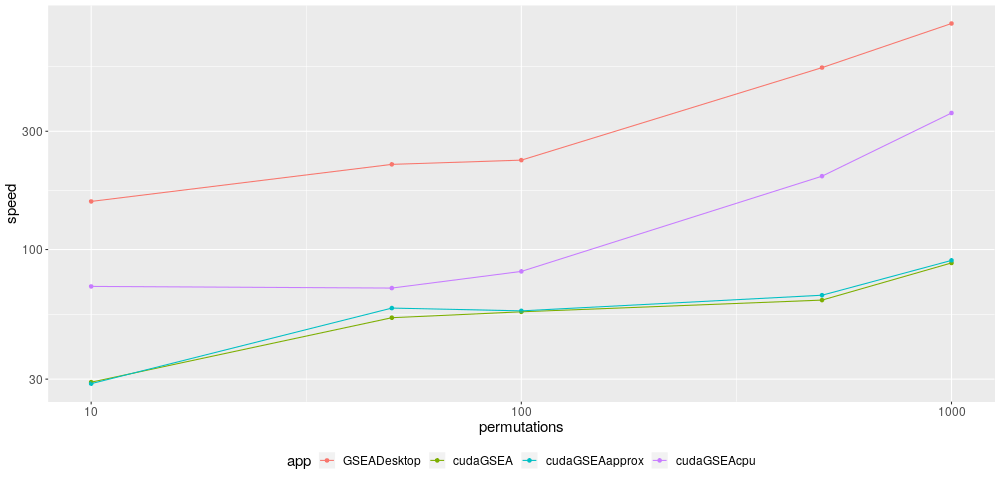

In [81]:
%%R -i speed_benchmark_data -w 1000
(
    ggplot(speed_benchmark_data, aes(x=permutations, y=speed, color=app))
    + geom_point()
    + theme(legend.position='bottom', legend.box='horizontal', text=element_text(size=15))
    + geom_line()
    + scale_y_continuous(trans='log10')
    + scale_x_continuous(trans='log10')

)

cudaGSEA cpu is the cuda implementation with the default (one-side) FDR calculation - but calculated on CPU, not a graphic card. Still faster than the Java (GSEADesktop) implementation.

## 3. cudaGSEA yields results close to those of reference implementation

In [84]:
# or is it molten?
melted_data = speed_benchmark_data[['auc', 'f1', 'app']].melt(id_vars=['app'])

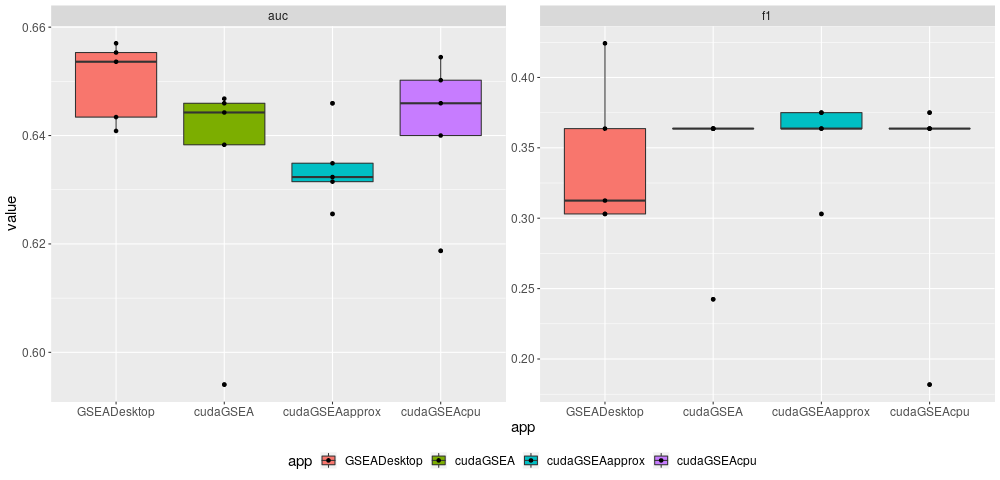

In [85]:
%%R -i melted_data -w 1000
(
    ggplot(melted_data, aes(x=app, y=value, fill=app))
    + facet_wrap('~ variable', scales='free_y')
    + geom_boxplot()
    + geom_point()
    + theme(legend.position='bottom', legend.box='horizontal', text=element_text(size=15))
)

On the above plot:
 - ROC AUC is calculated comparing row scores from signatures matching (floats normalized to 0-1, with 1 being for assumed indications) against a binary response vector (indications = 1, contraindications = 0)
 - F1 score is (obviously) calculated on a classification result, where indications were chosen as substances scoring above the threshold of top 10%.

Looking at the above plot it is difficult to interpret which method performs best:

- it may be that prioritization scores would have been better when using the reference GSEADesktop implementation,
- it may be that the cudaGSEA works better for classification problem.
- it seems likely that **there are just too few observations to draw solid conclusions.**

I somehow (weakly) support this claim below by showing how minuscule are the differences when compared to random distribution of the respective scores.

### How do those scores compare to a random distribution?

(given unequally distributed classes of indications and contraindications in this problem)

In [86]:
import random
from sklearn.metrics import f1_score, roc_auc_score
from data_sources.drug_connectivity_map import dcm

indications = len(dcm.identify_substances(data.indications_singatures))
contra = len(dcm.identify_substances(data.contraindications_singatures))

expected = [1] * indications + [0] * contra
indications / contra   # haven't found proof yet but simple ratio seems to give us expected f1 for unbalanced classes

0.34146341463414637

In [87]:
permutations_f1 = []
permutations_auc = []
permutations_classes = []
for i in range(1000):
    randomly_chosen = [random.choice([0, 1]) for j in range(indications + contra)]
    permutations_f1.append(f1_score(expected, randomly_chosen))
    permutations_classes.append(roc_auc_score(expected, randomly_chosen))

    randomly_chosen = [random.random() for j in range(indications + contra)]
    permutations_auc.append(roc_auc_score(expected, randomly_chosen))

In [88]:
permuatated = DataFrame(dict(
    f1=permutations_f1,
    auc=permutations_auc,
    auc_class=permutations_classes,
    app='permutations'
)).melt(id_vars='app')

In [89]:
melted_data = speed_benchmark_data[['auc', 'auc_class', 'f1', 'app']].melt(id_vars='app')
merged = concat([melted_data, permuatated])

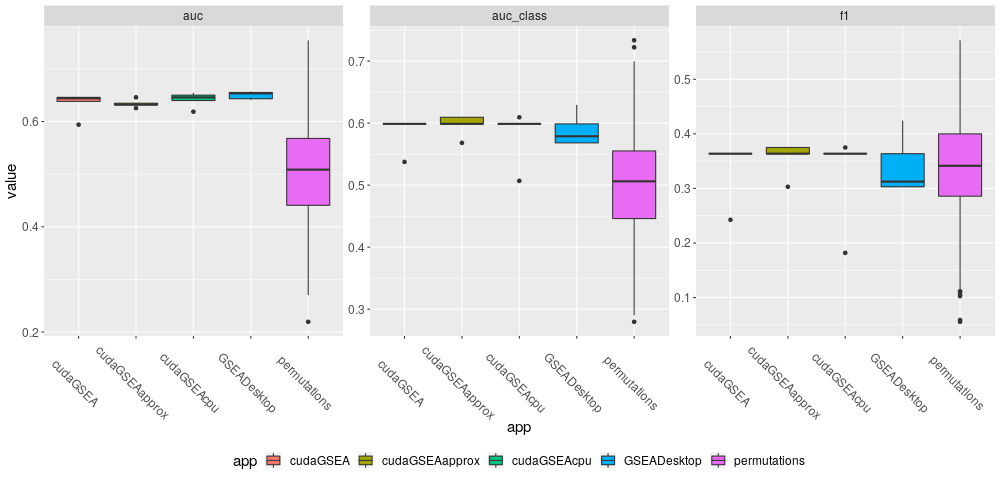

In [90]:
%%R -i merged -w 1000
(
    ggplot(merged, aes(x=app, y=value, fill=app))
    + facet_wrap('~ variable', scales='free_y')
    + geom_boxplot()
    + theme(legend.position='bottom', legend.box='horizontal', text=element_text(size=15), axis.text.x=element_text(angle=-45))
)

Here "auc_class" represents ROC AUC on classification result (obtained same way as for F1).

While F1 and AUC_class do seem highly correlated, F1 of GSEA Desktop (with given parameters) seems to be lower than expected BUT there are just too few repeats for GSEADesktop and I do not have power/time to compute more.

Below I take a closer look on two parameters for GSEA method: the FDR q-value cutoff and differential expression metrics.

## 4. Setting low FDR q-value cutoff results in low scoring function performance

In [13]:
import gc; gc.collect();

In [14]:
grid = [i/20 for i in range(1, 20)]
print(grid)

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


In [15]:
p = 1000
functions = []
for q in grid:
    gsea_score_phenotypes_cuda = shared_gsea_scorer(
        gsea_app=gsea_cuda,
        permutations=p, q_value_cutoff=q,
        metric='onepass_signal2noise'
    )
    functions.append(gsea_score_phenotypes_cuda)

In [16]:
fdr_cutoff_benchmark = partial(standard_brca_benchmark, functions)
fdr_cutoff_benchmark.keywords['processes'] = 15

In [18]:
fdr_results = []

In [ ]:
for i in range(10):
    fdr_results.append(fdr_cutoff_benchmark())

In [22]:
results_q_cutoff = concat(fdr_results)

In [23]:
results_q_cutoff.to_csv('cudaGSEA benchmarks/results_q_cutoff_new.csv')

In [7]:
from pandas import read_csv, DataFrame
results_q_cutoff = read_csv('cudaGSEA benchmarks/results_q_cutoff_new.csv', index_col=0)

In [8]:
q_value_data = DataFrame(dict(
    q_cutoff=results_q_cutoff.index.str.split('_').str[4],
    indications_f1=results_q_cutoff['indications:F1 Score'],
    containdications_f1=results_q_cutoff['contraindications:F1 Score'],
    f1_tradeoff=results_q_cutoff['indications:F1 Score'] - results_q_cutoff['contraindications:F1 Score'],
    auc=results_q_cutoff['contraindications:AUC ROC'],
    auc_class=results_q_cutoff['contraindications:AUC ROC classification'],
)).melt(id_vars='q_cutoff')

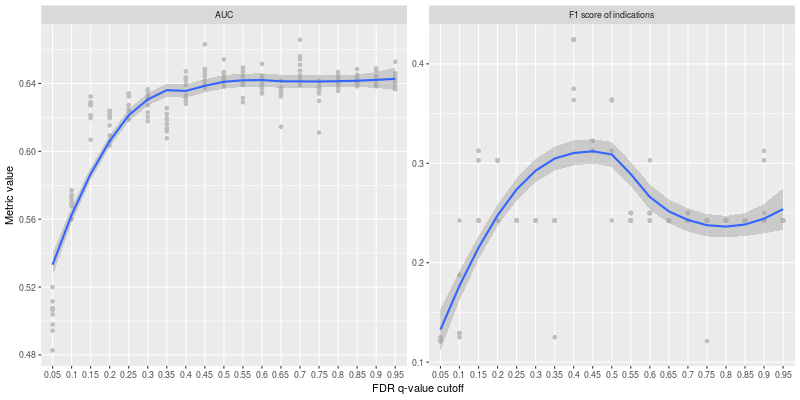

In [18]:
%%R -i q_value_data -w 800 -h 400
labels = c(
    'auc'='AUC',
    'indications_f1' = 'F1 score of indications'
)
(
    ggplot(
        q_value_data[q_value_data$variable %in% c('auc', 'indications_f1'),],
        aes(x=q_cutoff, y=value, group=variable)
    )
    + geom_point(color ='grey')
    + facet_wrap(' ~ variable', scales='free_y', labeller=as_labeller(labels))
    + stat_smooth(show.legend=T)
    + xlab('FDR q-value cutoff')
    + ylab('Metric value')
)

It would seem that choosing an FDR q-value between 0.4-0.5 could give the best distinction here. But this would have to be tested on another dataset(!)

Why is that the case? Well, the FDR filtering is for me essentially a de-noising procedure (I use FDR q-value to select considered disease gene-sets and then set weight of accepted gene_set to $1-\text{qFDR}$). Filtering out man gene-sets (very low threshold) I loose noise as well as the signal. But I do not want to loose signal.

One might assume that there is a magic number 0.5 which should separate the gene sets which have a useful signal from those that are just a noise. This indeed seems to be the case.

Another consideration is the distribution of FDR q-values. By the definition/nature of FDR I expect that most of the q-values will be high, with just a small fraction below $0.05$. Thus setting FDR threshold to $0.05$ would eliminate a lot of the signal (and a lot of noise as well). Actually, this is shown on the first figure in this notebook.

**Notes:**
- the above results are only valid for the "one-tailed" FDR (which was used for the tests) 
- the above results should be reevaluated on another dataset.

##### Supplementary plot (F1 scores):

In this simple case contraindications F1 is just inverse of indications F1 (as there are no other classes, e.g. controls to compare with and affect the F1 class-specific scores) - so:

$\text{F1}_{\text{tradeoff}} = 2 \cdot \text{F1}_{\text{indications}} = -2 \cdot \text{F1}_{\text{contraindications}} \approx 2 \cdot \text{AUC}_{\text{class}}$

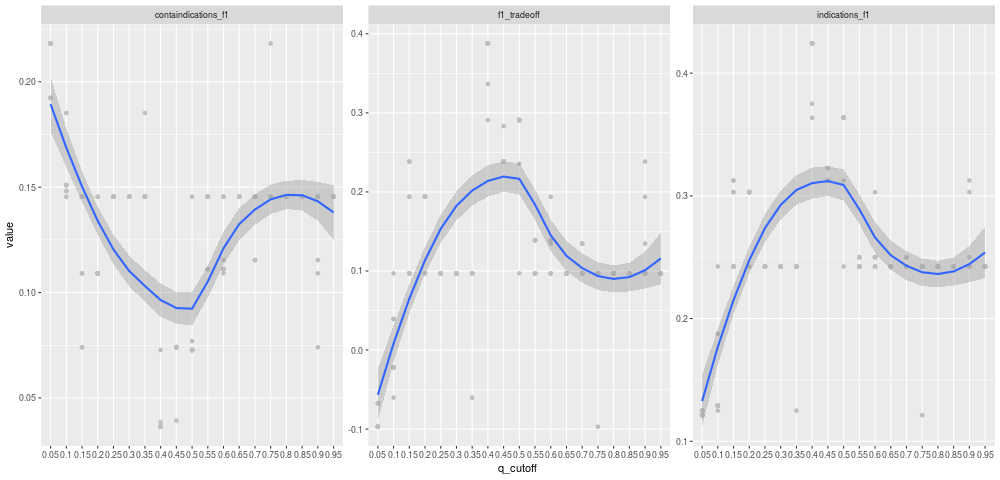

In [62]:
%%R -i q_value_data -w 1000
(
    ggplot(
        q_value_data[!q_value_data$variable %in% c('auc', 'auc_class'),],
        aes(x=q_cutoff, y=value, group=variable)
    )
    + geom_point(color ='grey')
    + facet_wrap(' ~ variable', scales='free_y')
    + stat_smooth(show.legend=T)
)

## 5. Comparison of cudaGSEA differential expression metrics

In [13]:
metrics = [
    'naive_diff_of_classes',
    'naive_ratio_of_classes',
    'naive_log2_ratio_of_classes',
    'stable_diff_of_classes',
    'stable_ratio_of_classes',
    'stable_log2_ratio_of_classes',
    'onepass_t_test',
    'onepass_signal2noise',
    'twopass_signal2noise',
    'twopass_t_test',
    'stable_signal2noise',
    'stable_t_test',
    'overkill_signal2noise',
    'overkill_t_test'
]

In [16]:
p = 250
q = 0.5
functions_metrics_test = []
for metric in metrics:
    for app, name in [(gsea_cuda, 'cudaGSEA'), (gsea_cuda_approx, 'cudaGSEAapprox')]:
        gsea_score_phenotypes_cuda = shared_gsea_scorer(
            gsea_app=app, metric=metric,
            permutations=p, q_value_cutoff=q,
        )
        rename_function(gsea_score_phenotypes_cuda, 'cudaGSEA', name)
        functions_metrics_test.append(gsea_score_phenotypes_cuda)

Signal-to-noise ratio and tTest can be only used on substances with at least three samples for each case and control, thus only such substances with >= 3 controls and signatures are included for those metrics.

To adjust for the differences in substances given to particular metrics I run the benchmark testing only signatures that have no less than three samples:

In [17]:
at_least_3_metrics_benchmark = partial(
    standard_benchmark, funcs=functions_metrics_test,
    indications_signatures=data.indications_singatures.substances_with_at_least_n_cases_and_controls(3),
    contraindications_signatures=data.contraindications_singatures.substances_with_at_least_n_cases_and_controls(3),
    # well BRCA data has much more than three cases and controls - no need to select
    query_expression=data.brca_with_controls,
    query_signature=None, control_signatures=None,
)
at_least_3_metrics_benchmark.keywords['processes'] = 7

In [46]:
results_min_3 = []
at_least_3_metrics_benchmark()      # cache generation

for i in range(10):
    result = at_least_3_metrics_benchmark(force_multiprocess_all=True)
    results_min_3.append(result)

In [30]:
metrics_results_min_3_df = concat(results_min_3)
metrics_results_min_3_df.to_csv('cudaGSEA benchmarks/metrics_results_min_3_samples_with_approximate.csv')

In [26]:
metrics_results_min_3_df = read_csv('cudaGSEA benchmarks/metrics_results_min_3_samples_with_approximate.csv', index_col=0)

In [27]:
def extract_metrics_meta(df):
    return DataFrame(dict(    
        auc_all=df['contraindications:AUC ROC'],
        auc_selected=df['contraindications:AUC ROC classification'],
        metric=df.index.str.split('_').str[9:].str.join('_'),
        app=df.index.str.split('_').str[0],
        group=df.index.str.split('_').str[9],
        time=df['Time']
    ))

In [28]:
metrics_data_min_3 = extract_metrics_meta(metrics_results_min_3_df)

### 5.1 Ratio-of-classes metrics results are highly variable

Even when very stable F1/"AUC on classification" is used:

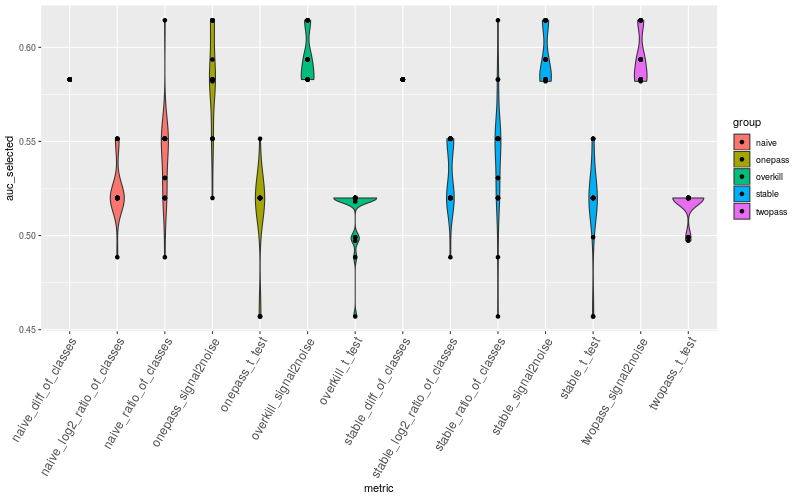

In [45]:
%%R -i metrics_data_min_3 -w 800 -h 500 -u px
(
    ggplot(metrics_data_min_3, aes(x=metric, y=auc_selected, group=metric, fill=group))
    + geom_violin() + geom_point()
    + theme(axis.text.x=element_text(angle=60, hjust=1, size=12))
)

Thus this metrics will be excluded on following plots to make them more interpretable:

In [29]:
without_ratio_of_classes = metrics_data_min_3[~metrics_data_min_3.metric.str.contains('ratio_of_classes')]

(please, note the shift from y=auc_selected to y=auc - which seems better for describing the overall trends - in the following examples)

### 5.2 Signal2Noise is the best for indication/contraindication prioritization

while tTest produces results surprisingly lower than Signal2Noise, sometimes even lower than the naive metrics.

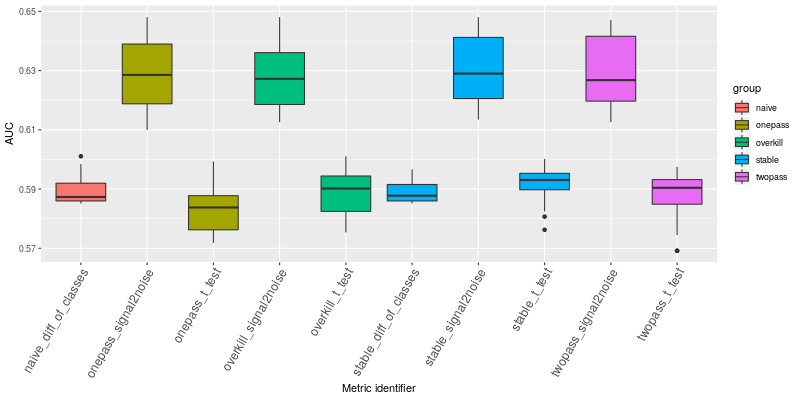

In [35]:
%%R -i without_ratio_of_classes -w 800 -h 400 -u px
(
    ggplot(without_ratio_of_classes, aes(x=metric, y=auc_all, group=metric, fill=group))
    + geom_boxplot()
    + theme(axis.text.x=element_text(angle=60, hjust=1, size=12))
    + ylab('AUC')
    + xlab('Metric identifier')
)

The low performance of t-test based metrics (or relatively higher performance of difference of classes and much higher performance of S2N) is surprising. Overall there is no much difference between the t-test and S2N thus such a difference was not expected:
  - My intuition would be that as the number of cases (candidate substances were tested in different numbers and combinations of cells) and controls can vary between substances greatly (e.g. because there are different numbers of controls per cell line/concentration), the introduction number of samples may not be well correlated with the standard deviation estimate.
  - A simpler, explanation would be the potential for numerical issues - squaring standard deviation and then taking a square root is prone to introduce computational errors, although:

### 5.3 There are no striking benefits of using implementations with improved numerical properties of S2N or tTest

Where by numerically improved I mean from two-pass, stable, overkill groups.

In [42]:
s2n_and_ttest = without_ratio_of_classes[
    without_ratio_of_classes.metric.str.contains('signal2noise|t_test')
]
s2n_and_ttest['metric_type'] = s2n_and_ttest.metric.apply(
    lambda x: 'Signal2Noise' if 'signal2noise' in x else 'tTest'
)
s2n_and_ttest.group = pd.Categorical(
    s2n_and_ttest.group, ordered=True,
    categories=['onepass', 'twopass', 'stable', 'overkill']
)

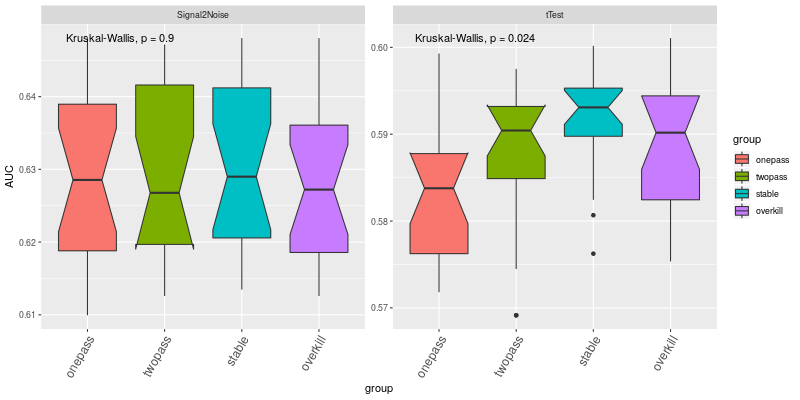

In [53]:
%%R -i s2n_and_ttest -w 800 -h 400 -u px
(
    ggplot(s2n_and_ttest, aes(x=group, y=auc_all, group=group, fill=group))
    + geom_boxplot(notch=T)
    + facet_wrap('. ~ metric_type', scales='free_y')
    + theme(axis.text.x=element_text(angle=60, hjust=1, size=12))
    + scale_fill_discrete()
    + ylab('AUC')
    + ggpubr::stat_compare_means()
)

### 5.4 The major trends are consistent regardless of the q-FDR calculation used

and of the type of evaluation metric (Full AUC / AUC on binary classification).

In [50]:
melted = without_ratio_of_classes.melt(id_vars=['metric', 'app', 'group', 'time'])

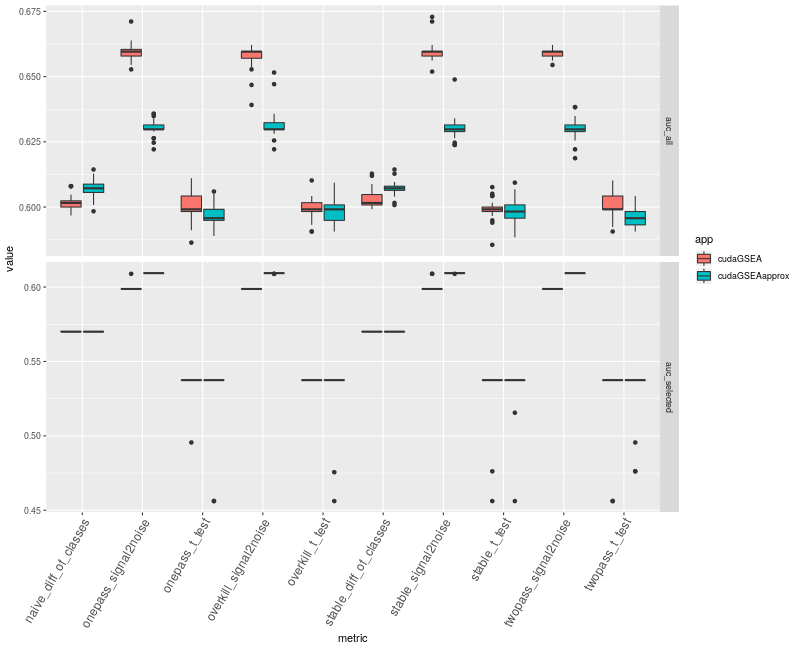

In [61]:
%%R -i melted -w 800 -h 650 -u px
(
    ggplot(melted, aes(x=metric, y=value, group=interaction(metric, app), fill=app))
    + geom_boxplot()
    + facet_grid('variable ~ .', scales='free')
    + theme(axis.text.x=element_text(angle=60, hjust=1, size=12))
)

### 5.5 Benchmark with unconstrained signatures pool

Having previously computed 25 repeats for samples-count-unadjusted benchmark, I include two figures as some of the findings are shared between the size adjusted and unadjusted benchmark and those provide additional boost in confidence to these findings:

In [16]:
metrics_benchmark = partial(standard_brca_benchmark, functions_metrics_test)
metrics_benchmark.keywords['processes'] = 7

In [140]:
discarded_result_with_cache_generation = metrics_benchmark()
metrics_results = []

for i in range(25):
    result = metrics_benchmark(force_multiprocess_all=True)
    metrics_results.append(result)

In [21]:
metrics_results_df = concat(metrics_results)
metrics_results_df.to_csv('cudaGSEA benchmarks/metrics_results_with_approximate.csv')

In [32]:
metrics_data = extract_metrics_meta(metrics_results_df)

#### Ratio-of-classes metrics results are highly variable

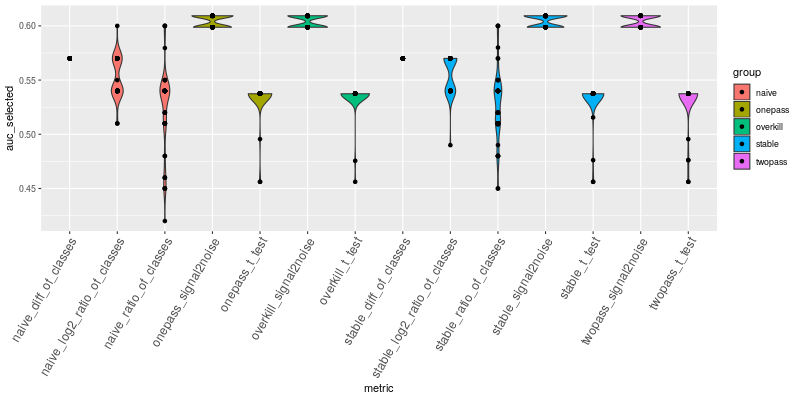

In [39]:
%%R -i metrics_data -w 800 -h 400 -u px
(
    ggplot(metrics_data, aes(x=metric, y=auc_selected, group=metric, fill=group))
    + geom_violin() + geom_point()
    + theme(axis.text.x=element_text(angle=60, hjust=1, size=12))
)

In [33]:
without_ratio_of_classes = metrics_data[~metrics_data.metric.str.contains('ratio_of_classes')]

#### Signal2Noise is the best for indication/contraindication prioritization

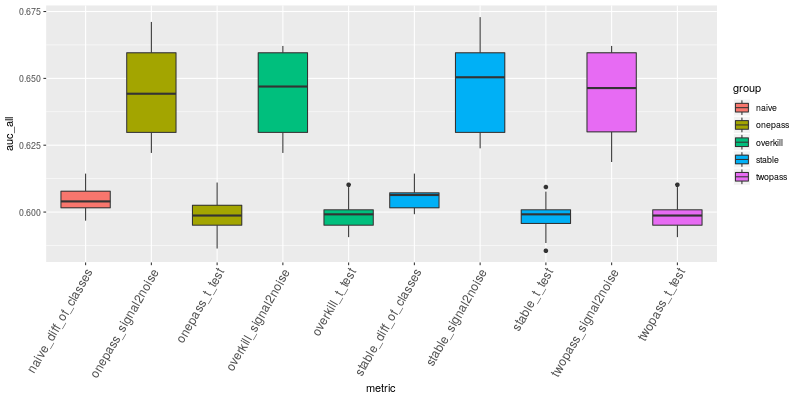

In [41]:
%%R -i without_ratio_of_classes -w 800 -h 400 -u px
(
    ggplot(without_ratio_of_classes, aes(x=metric, y=auc_all, group=metric, fill=group))
    + geom_boxplot()
    + theme(axis.text.x=element_text(angle=60, hjust=1, size=12))
)

## 6. Naive metrics are faster. A little bit.

Stable metrics would appear to be fast as well, as there were stable implementations of naive metrics in this group - to account for that I moved these to a separate group:

In [93]:
stable_but_naive =  [
    'stable_diff_of_classes', 'stable_ratio_of_classes', 'stable_log2_ratio_of_classes'
]
time_data = copy(metrics_data_min_3)
rows = time_data.metric.isin(stable_but_naive)
time_data.loc[rows, 'group'] = 'stable naive'

In [94]:
by_expected_time_of_execution = [
    'naive', 'stable naive', 'onepass', 'twopass', 'stable', 'overkill'
]
time_data.group = pd.Categorical(
    time_data.group, ordered=True,
    categories=by_expected_time_of_execution
)

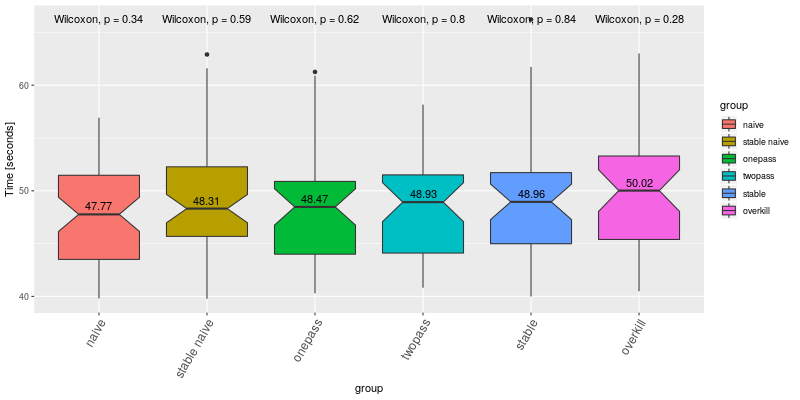

In [102]:
%%R -i time_data -w 800 -h 400 -u px
require(ggpubr)
(
    ggplot(time_data, aes(x=group, y=time, group=group, fill=group))
    + geom_boxplot(notch=T)
    + theme(axis.text.x=element_text(angle=60, hjust=1, size=12))
    + stat_summary(aes(label=round(..y.., 2)), geom='text', fun.y=median, vjust=-0.5)
    + scale_fill_discrete()
    + ylab('Time [seconds]')
    + stat_compare_means(ref.group='.all.')
)

- The medians are ordered in the same way as one would expect based on the complexity of performed calculations,
- though the differences are not significant though (neither in statistical nor in practical sense)... 
- which shows that there is no particular time boost from choosing one metric over another (though overkill may indeed be an overkill).

In [96]:
metrics_data_min_3.groupby('group').time.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
naive,60.0,47.807525,4.684182,39.805497,43.507471,47.770097,51.472827,56.929315
stable naive,60.0,49.195297,5.082489,39.780626,45.684799,48.314623,52.275995,62.913114
onepass,40.0,48.389050,5.268155,40.297318,44.000151,48.474208,50.890736,61.260355
twopass,40.0,48.275824,4.735744,40.821305,44.103282,48.927450,51.507691,58.164436
stable,40.0,49.170842,6.166654,39.985319,44.988109,48.956334,51.727230,66.230072
overkill,40.0,49.507933,5.203727,40.487900,45.392648,50.020743,53.295069,63.006775


# Conclusions

- Using FDR approximation is not worth it (little or no speed-up, a lot of explaining why my method behaves differently from the standard GSEA implementation),
- q-FDR = 0.5 sounds like a good cutoff,
- cudaGSEA should be used instead of GSEADesktop as it is 6 times faster,
- using recommended two_pass_signal2ratio metric should give good speed / outcome tradeoff - and is anyway recommended by the authors.